# Analyse, classification et indexation des données: feuille 6
### Classifieur bayésien

Dans la première partie de ce TD on s’appuie sur l’exemple du cours qui consiste à séparer des poissons en deux classes : bars et saumons. La classification sera faite à partir d’une seule caractéristique (la longueur) dans un premier temps, puis à partir de deux caractéristiques (longueur et brillance). En d’autres termes, le descripteur sera d’abord de dimension 1 puis de dimension 2.

#### Données
Dans cet exercice, nous allons travailler avec un fichier (<code>salmon_seabass.csv</code>) contenant des informations sur la longueur et la brillance de deux classes de poissons : les saumons et les bars.
Le fichier est disponible à l'adresse : 

https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv

1- Chargez le fichier, et notez que la colonne <code>species</code> indique la catégorie du poisson : 

    - 0 : il s'agit d'un saumon 
    - 1 : il s'agit d'un bar


In [277]:
import pandas as pa

In [278]:
data = pa.read_csv("salmon_seabass.csv", sep=";")

In [279]:
data.head(10)

,lightness,width,species
0,9.710457,8.673699,0
1,6.528089,7.330887,0
2,1.770695,7.599677,0
3,4.819293,7.328198,0
4,6.769638,8.575629,0
5,3.623250,7.221906,0
6,6.591439,6.936439,0
7,2.924506,8.552978,0
8,5.196399,7.576571,0
9,8.047453,8.361587,0


2- Affichez le nombre de valeurs fournies pour chacune des deux classes. On les nommera <code>sizeVTSaumon</code>
et <code>sizeVTBar</code>. 

In [280]:
sizeVTSaumon = (data["species"]==0).sum()
sizeVTBar = (data["species"]==1).sum()
print(sizeVTSaumon)
print(sizeVTBar)

1000
500


### Exercice 1. classifieur avec une seule dimension

### 1.0 Préalable
Dans un premier temps, nous allons considérer un seul descripteur : la longueur <code>width</code> des poissons. 

a- Mélanger les données.

In [281]:
mix_data = data.sample(frac=1).reset_index(drop=True)
mix_data.head(10)

,lightness,width,species
0,8.152582,7.444339,0
1,7.133654,9.062184,1
2,6.769638,8.575629,0
3,6.797340,7.949469,0
4,16.919790,11.335826,1
5,8.228239,12.098869,1
6,7.542873,7.613606,0
7,4.725922,9.376949,0
8,3.536316,8.820471,0
9,5.732462,8.282529,0


b- Créer deux variables $X$ et $y$ respectivement la longueur du poisson et son espèce

In [282]:
import matplotlib.pyplot as plt
%matplotlib inline

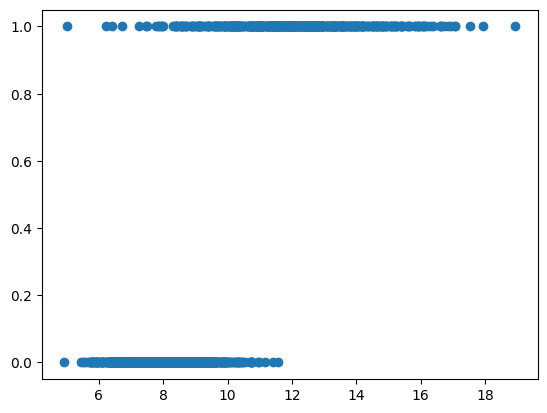

In [283]:
X = mix_data["width"]
y = mix_data["species"]
plt.scatter(X, y)
plt.show()

c-  Découper les données en deux parties : 80% pour l'entrainement et 20% pour le test.

In [284]:
from sklearn.model_selection import train_test_split

In [285]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test
Y_test

1116    0
1368    1
422     0
413     1
451     0
       ..
983     1
799     0
1265    0
1150    0
824     1
Name: species, Length: 300, dtype: int64

#### 1.1. Classifieur ML

a- Calculer les estimateurs non biaisés de la moyenne et de l'écart type pour chacune des espèces de poisson. Attention, il faut travailler sur la portion d'entraînement du dataset.  


In [286]:
import numpy as np

In [287]:
salmon_train = X_train[Y_train == 0]
bass_train = X_train[Y_train == 1]
salmon_mean, bass_mean = salmon_train.mean(), bass_train.mean()
salmon_standard, bass_standard = salmon_train.std(), bass_train.std()
salmon_mean, salmon_standard, bass_mean, bass_standard

(np.float64(8.079613578044057),
 np.float64(0.9866498731430554),
 np.float64(12.067205253621177),
 np.float64(2.055001680011212))

b- Dessiner les courbes des lois normales correspondant à la fonction de maximum de vraisemblance. Indiquer la frontière de décision. Quelle est l'espèce prédite d'un poisson de longueur 12 ?

In [288]:
import scipy.stats

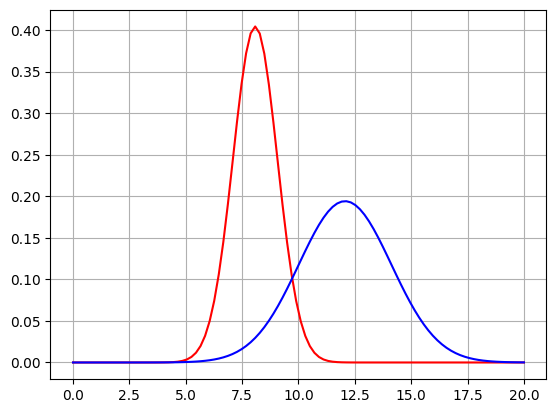

In [289]:
x_min, x_max = 0, 20
x = np.linspace(x_min, x_max, 100)


y_salmon = scipy.stats.norm.pdf(x, salmon_mean, salmon_standard)
y_bass = scipy.stats.norm.pdf(x, bass_mean, bass_standard)

plt.grid()
plt.plot(x, y_salmon, c='red')
plt.plot(x, y_bass, c='b')
plt.show()

c- Evaluer la qualité du modèle entrainé.

In [290]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [291]:
X_test = list(X_test)

In [303]:
y_pred = []
for i in range (len(X_test)):
    if scipy.stats.norm.pdf(X_test[i], salmon_mean, salmon_standard) > scipy.stats.norm.pdf(X_test[i], bass_mean, bass_standard):
        y_pred.append(0)
    else:
        y_pred.append(1)
cm = confusion_matrix(Y_test, y_pred)
print(cm)

acc = accuracy_score(Y_test, y_pred)
print('{:.20%}'.format(acc))

[[195   9]
 [ 11  85]]
93.33333333333332859638%


#### 1.2. Classifieur MAP

a- Ecrire une fonction <code>classify()</code> permettant également de classifier les poissons mais en utilisant cette fois un classifieur a posteriori.

In [304]:
def classify(item):
    r_salmon = len(salmon_train)/len(X_train)
    r_bass = len(bass_train)/len(X_train)
    # print(r_salmon)
    # print(r_bass)
    p_salmon = scipy.stats.norm.pdf(item, salmon_mean, salmon_standard)
    p_bass = scipy.stats.norm.pdf(item, bass_mean, bass_standard)
    if p_salmon * r_salmon > p_bass * r_bass:
        return 0
    return 1

print("class prédite pour item 0 :", classify(X_test[0]))

class prédite pour item 0 : 0


b- Evaluer ce classifieur 

In [305]:
y_pred = []
for i in range (len(X_test)):
    y_pred.append(classify(X_test[i]))
    
cm = confusion_matrix(Y_test, y_pred)
print(cm)

acc = accuracy_score(Y_test, y_pred)
print('{:.20%}'.format(acc))

[[199   5]
 [ 16  80]]
93.00000000000000000000%


### Exercice 2. Classifieur avec deux descripteurs 

Dans cet exercice, nous allons considérer le dataset dans sa globalité. Nous allons donc baser notre classification sur les deux descripteurs <code>width</code> et <code>lightness</code>.

Reprogrammer et tester les deux classifieurs vus dans l'exercice 1. Quel est l'impact du rajout du nouveau descripteur ?

### Exercice 3. Bayes avec <code>sklearn</code>

Comparer vos résultats avec ceux obtenus avec un classifieur de Bayes de la bibliothèque <code>sklearn</code>.

In [306]:
from sklearn.naive_bayes import GaussianNB